In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import networkx as nx
from helpers import eig
from sklearn.cluster import KMeans

# Exercise 3

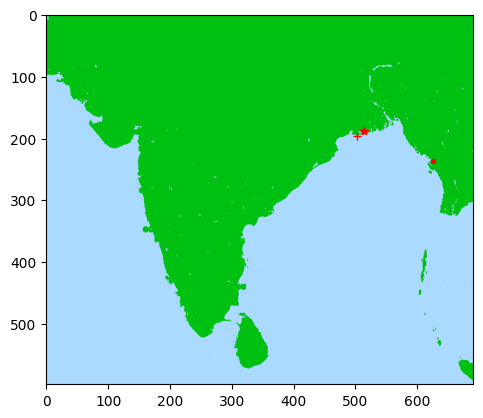

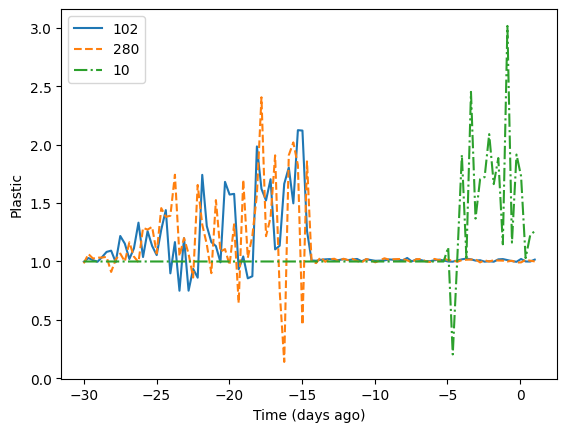

In [2]:
mat = scipy.io.loadmat('bengali_cleanup.mat')
A = plt.imread('bengali_map.png')

timeseries = mat['timeseries']
tv = mat['tv'][0]
x_coords = mat['x_coords']
y_coords = mat['y_coords']
jv = np.array([101, 279, 9])  # Since Python index from 0 we subtract 1 on every element

plt.plot(y_coords[jv[0]],x_coords[jv[0]], 'r*', y_coords[jv[1]],x_coords[jv[1]], 'r+', y_coords[jv[2]],x_coords[jv[2]], 'r.')
plt.imshow(A)
plt.figure()
plt.plot(tv, timeseries[jv[0],:], '-', label = str(jv[0] + 1))
plt.plot(tv,timeseries[jv[1],:], '--', label = str(jv[1] + 1))
plt.plot(tv,timeseries[jv[2],:], '-.', label = str(jv[2] + 1))
plt.ylabel("Plastic")
plt.xlabel("Time (days ago)")
plt.legend()

### A)

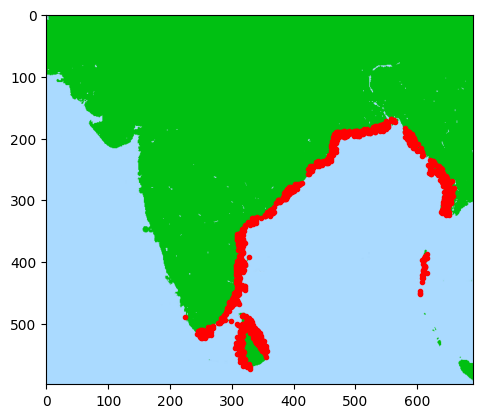

In [3]:
# Show all the stations on the map
plt.figure()
plt.imshow(A)
for i in range(937):
    plt.plot(y_coords[i],x_coords[i], 'r.')


### B) 

In [4]:
# Compute distance matrix in a vectorized way
def build_distance(M): 
    S = np.sum(M.T**2, axis=0, keepdims=True)
    S = np.sqrt(np.maximum(0,S + S.T - 2 * M.dot(M.T)))
    np.fill_diagonal(S, 0)
    return S

Dist = build_distance(timeseries)
print(Dist[279, 101])
print(Dist[101, 9])
print(Dist[279, 9])

3.3482962975090693
4.610107624516744
4.839156486556743


### C)

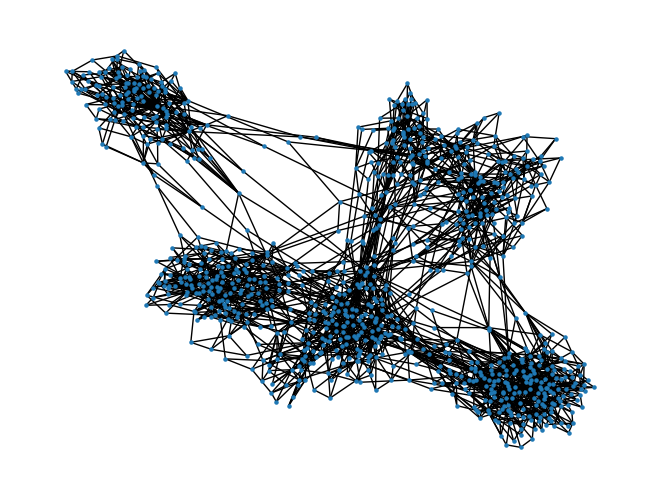

In [5]:
def knn(Dist, k):
    n = Dist.shape[0]
    W = np.zeros((n, n))
    knn_indices = np.argsort(Dist, axis=1)[:, :k+1]
    
    for i in range(n):
        W[i, knn_indices[i, 1:]] = 1
        W[knn_indices[i, 1:], i] = 1
    return W 
    

W = knn(Dist, 3)
G = nx.from_numpy_array(W)
nx.draw(G, node_size = 5)




### D)

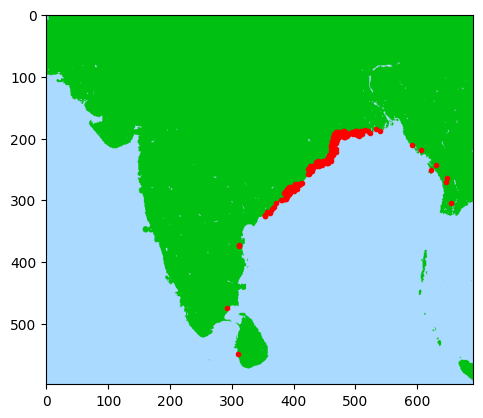

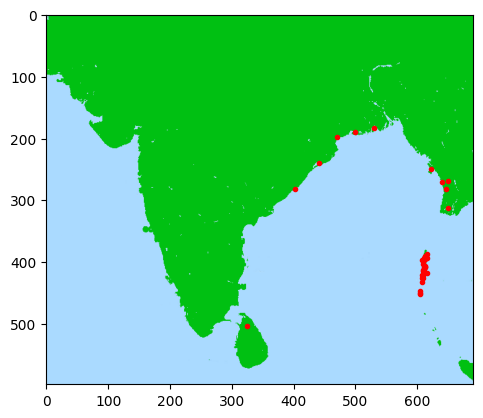

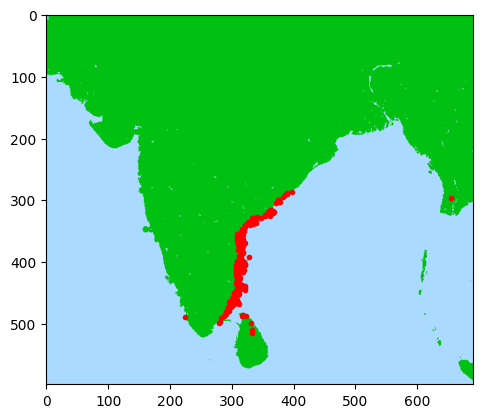

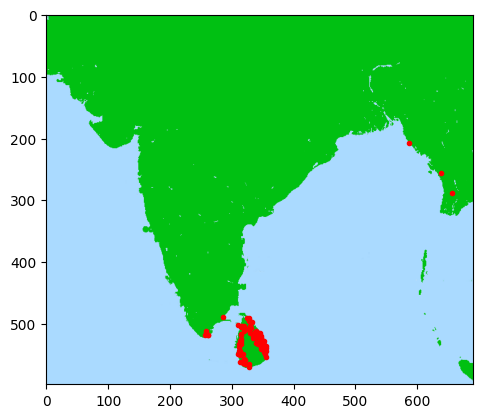

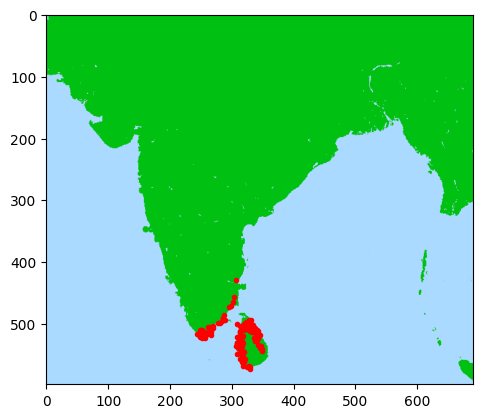

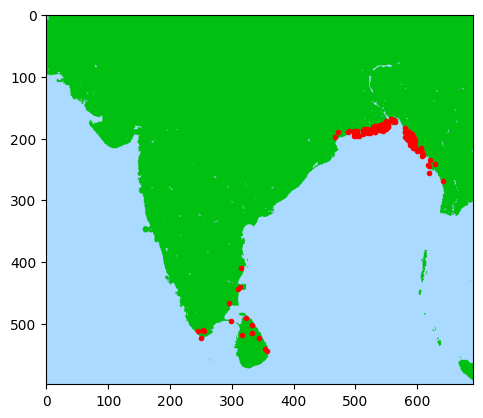

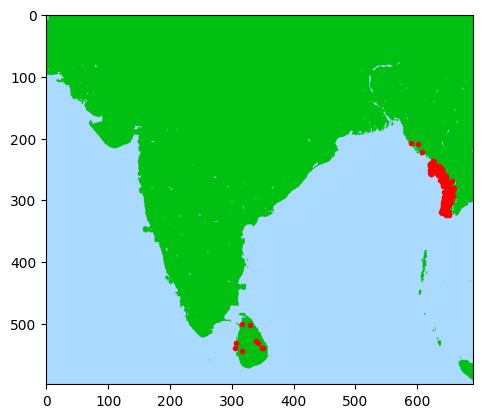

In [6]:
def cluster(W, k):
    D = np.diag(np.sum(W, axis = 1))
    L = D - W
    _, eigvectors = eig(L)
    U = eigvectors[:,:k]
    kmeans = KMeans(n_clusters = k).fit(U)
    return kmeans.labels_

clusters = cluster(W, 7)

def plot_cluster(image, clusters, cluster_nr):
    group = []
    for i in range(len(clusters)):
        if clusters[i] == cluster_nr:
            group.append(i)
    plt.figure()
    plt.imshow(image)
    for i in group:
        plt.plot(y_coords[i],x_coords[i], 'r.')

plot_cluster(A, clusters, 0)
plot_cluster(A, clusters, 1)
plot_cluster(A, clusters, 2)
plot_cluster(A, clusters, 3)
plot_cluster(A, clusters, 4)
plot_cluster(A, clusters, 5)
plot_cluster(A, clusters, 6)

### E)

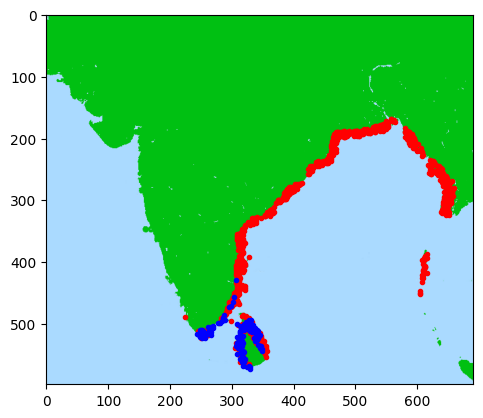

In [7]:
clusters = cluster(W, 2)

group0 = []
group1 = []
for i in range(len(clusters)):
    if clusters[i] == 0:
        group0.append(i)
for i in range(len(clusters)):
    if clusters[i] == 1:
        group1.append(i)
plt.figure()
plt.imshow(A)
for i in group0:
    plt.plot(y_coords[i],x_coords[i], 'r.')
for i in group1:
    plt.plot(y_coords[i],x_coords[i], 'b.')